# CNN-BiLSTM-Attention Model for Time-Series Research Project 
- Researched by Shane Stoll
- Advised by Uzma Mushtaque

# Libraries to import

In [93]:
from datetime import datetime
import os
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, SimpleRNN, GRU, Dense, Dropout, Bidirectional,
    Conv1D, MaxPooling1D, Flatten, Input, Attention, Concatenate, Reshape
)
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, Adagrad, Adadelta, SGD
from tensorflow.keras.callbacks import EarlyStopping

import yfinance as yf
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pandas_ta as ta
from projectpro import model_snapshot, checkpoint

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Steps to Implement the CNN-BiLSTM-Attention Model

## 1. Preprocessing the Stock Data
- Normalize the dataset using Min-Max scaling.
- Reshape the data to fit the CNN input format.

In [94]:
# Load dataset
def load_and_preprocess_data(filepath, column='High', window_size=60):
    data = pd.read_csv(filepath, index_col='Date', parse_dates=True)
    data = data[[column]]
    
    # Scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    # Create sequences
    X, y = [], []
    for i in range(len(scaled_data) - window_size):
        X.append(scaled_data[i:i + window_size])
        y.append(scaled_data[i + window_size])

    X, y = np.array(X), np.array(y)

    # Split into training and testing sets
    train_size = int(0.8 * len(X))
    return X[:train_size], y[:train_size], X[train_size:], y[train_size:], scaler

## 2. CNN for Feature Extraction
- Use 1D convolutional layers to capture short-term trends.
- Apply MaxPooling to reduce dimensionality.

In [95]:
# CNN Model for Feature Extraction
def build_cnn(input_shape):
    cnn_input = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(cnn_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    cnn_model = Model(inputs=cnn_input, outputs=x)
    return cnn_model

## 3. Bi-Directional LSTM for Temporal Dependencies
- Implement Bidirectional LSTM (BiLSTM) to capture sequential patterns in both forward and backward directions.
- Apply Dropout to prevent overfitting.

In [96]:
# Bi-LSTM Model (Reusing Existing Function)
def build_bilstm(n_steps=60, units=300, dropout_rate=0.3):
    bilstm_input = Input(shape=(n_steps, 1))
    x = Bidirectional(LSTM(units, activation='relu', return_sequences=True))(bilstm_input)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(units, activation='relu', return_sequences=True))(x)
    bilstm_model = Model(inputs=bilstm_input, outputs=x)
    return bilstm_model

## 4. Attention Mechanism
- Add an attention layer to focus on the most important time steps.
- Improve the interpretability of the model by weighting significant time points.

In [ ]:
from tensorflow.keras.layers import Dense, Multiply, Permute
from tensorflow.keras.layers import Attention

def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Flatten()(attention)

## 5. Fully Connected Output Layer
- Use a Dense layer with a single output neuron to predict the stock price.

In [98]:
# CNN-BiLSTM-Attention Hybrid Model
def build_hybrid_model(n_steps=60, units=300, dropout_rate=0, learning_rate=0.0005):
    input_shape = (n_steps, 1)
    
    # Build CNN and BiLSTM models
    cnn_model = build_cnn(input_shape)
    bilstm_model = build_bilstm(n_steps, units, dropout_rate)

    # Attention Mechanism
    attention_out = attention_layer(bilstm_model.output)

    # Concatenating CNN and BiLSTM outputs
    merged = Concatenate()([cnn_model.output, attention_out])
    output_layer = Dense(1)(merged)

    # Final Model
    model = Model(inputs=[cnn_model.input, bilstm_model.input], outputs=output_layer)
    optimizer = RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

## 6. Compile and Train the Model
- Use an optimizer such as RMSprop or Adam.
- Evaluate performance using MSE, RMSE, MAE, and MAPE.

In [99]:
# Train the Model
def train_hybrid_model(model, X_train, y_train, X_test, y_test, epochs=200, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(
        [X_train, X_train], y_train, 
        epochs=epochs, batch_size=batch_size,
        validation_data=([X_test, X_test], y_test),
        callbacks=[early_stopping]
    )
    
    return model, history

In [100]:
# Evaluate and Plot Predictions
def evaluate_model(model, X_test, y_test, scaler, title="Hybrid Model Stock Price Prediction"):
    predictions = model.predict([X_test, X_test])
    predictions = scaler.inverse_transform(predictions)
    y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = np.mean((predictions - y_test_scaled)**2)
    mae = np.mean(abs(predictions - y_test_scaled))
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((predictions - y_test_scaled) / y_test_scaled)) * 100

    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Percentage Error: {mape}%")

    plt.figure(figsize=(12,6))
    plt.plot(y_test_scaled, label="Actual Prices")
    plt.plot(predictions, label="Predicted Prices", linestyle='dashed', color='red')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

    return mse, mae, rmse, mape

Epoch 1/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - loss: 2.6846e-04 - val_loss: 0.0061
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 25s 271ms/step - loss: 2.5216e-05 - val_loss: 0.0053
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 25s 271ms/step - loss: 1.9392e-05 - val_loss: 0.0039
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 25s 272ms/step - loss: 2.0085e-05 - val_loss: 0.0029
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 25s 271ms/step - loss: 1.6016e-05 - val_loss: 0.0031
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 25s 272ms/step - loss: 1.4728e-05 - val_loss: 0.0028
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 25s 275ms/step - loss: 1.3855e-05 - val_loss: 0.0023
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 25s 273ms/step - loss: 1.5648e-05 - val_loss: 0.0027
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 25s 275ms/step - loss: 1.3321e-05 - val_loss: 0.0024
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 25s 275ms/step - loss: 1.2492e-05 - val_loss: 0.0022
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 25s 276ms/step - loss: 1.2508e-05 - val

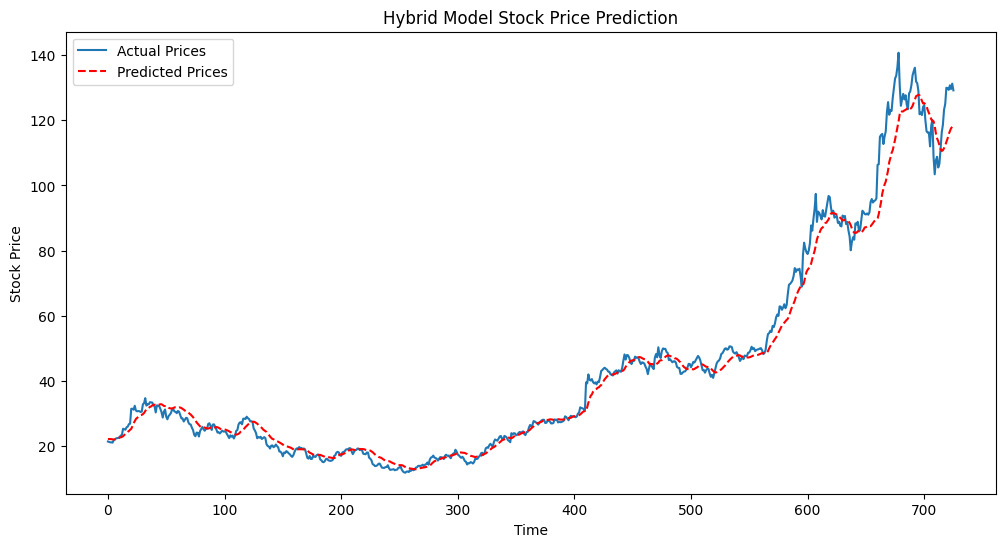

In [101]:
# Run the Hybrid Model on Stock Data
if __name__ == "__main__":
    X_train, y_train, X_test, y_test, scaler = load_and_preprocess_data('nvidia_stock_data.csv')

    hybrid_model = build_hybrid_model()
    hybrid_model, history = train_hybrid_model(hybrid_model, X_train, y_train, X_test, y_test)

    evaluate_model(hybrid_model, X_test, y_test, scaler)

Epoch 1/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 36s 337ms/step - loss: 0.0051 - val_loss: 0.0028
Epoch 2/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 26s 289ms/step - loss: 5.7767e-04 - val_loss: 0.0024
Epoch 3/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 26s 289ms/step - loss: 5.3809e-04 - val_loss: 0.0025
Epoch 4/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 27s 296ms/step - loss: 3.5544e-04 - val_loss: 0.0016
Epoch 5/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 26s 287ms/step - loss: 2.9187e-04 - val_loss: 0.0014
Epoch 6/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 26s 289ms/step - loss: 2.8277e-04 - val_loss: 0.0028
Epoch 7/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 27s 291ms/step - loss: 1.8378e-04 - val_loss: 0.0030
Epoch 8/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 30s 333ms/step - loss: 1.8587e-04 - val_loss: 0.0018
Epoch 9/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 28s 306ms/step - loss: 1.5708e-04 - val_loss: 0.0012
Epoch 10/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 26s 287ms/step - loss: 2.1644e-04 - val_loss: 0.0044
Epoch 11/200
91/91 ━━━━━━━━━━━━━━━━━━━━ 26s 287ms/step - loss: 1.4204e-04 - val_los

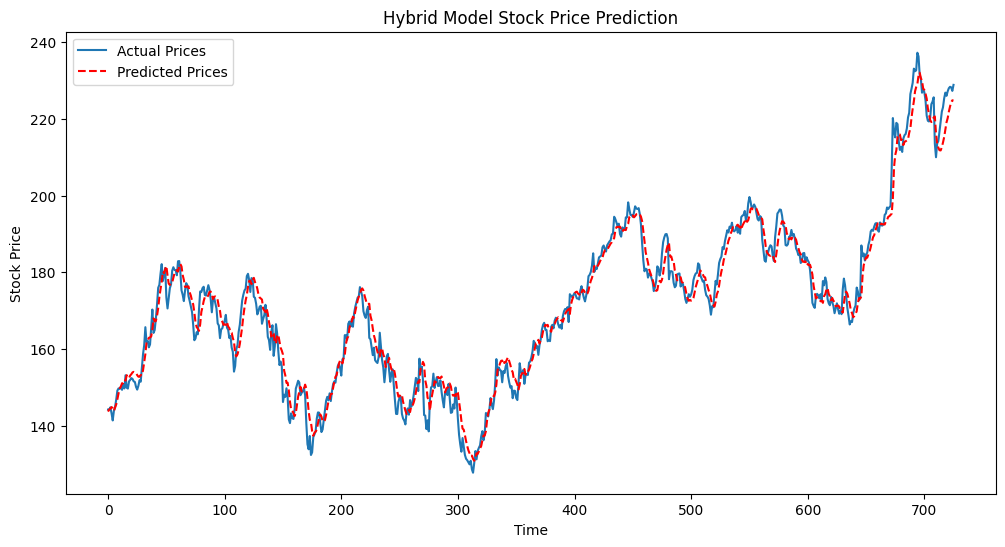

In [102]:
# Run the Hybrid Model on Stock Data
if __name__ == "__main__":
    X_train, y_train, X_test, y_test, scaler = load_and_preprocess_data('apple_stock_data.csv')

    hybrid_model = build_hybrid_model()
    hybrid_model, history = train_hybrid_model(hybrid_model, X_train, y_train, X_test, y_test)

    evaluate_model(hybrid_model, X_test, y_test, scaler)

Epoch 1/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 284ms/step - loss: 0.0047 - val_loss: 0.0093
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 25s 282ms/step - loss: 0.0011 - val_loss: 0.0096
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 25s 290ms/step - loss: 9.0911e-04 - val_loss: 0.0058
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 299ms/step - loss: 5.6414e-04 - val_loss: 0.0033
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 292ms/step - loss: 4.2550e-04 - val_loss: 0.0210
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 293ms/step - loss: 4.5803e-04 - val_loss: 0.0024
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 293ms/step - loss: 2.8252e-04 - val_loss: 0.0021
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 294ms/step - loss: 3.4847e-04 - val_loss: 0.0019
Epoch 9/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 292ms/step - loss: 2.8971e-04 - val_loss: 0.0052
Epoch 10/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 297ms/step - loss: 2.4144e-04 - val_loss: 0.0064
Epoch 11/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 294ms/step - loss: 2.4243e-04 - val_loss: 0

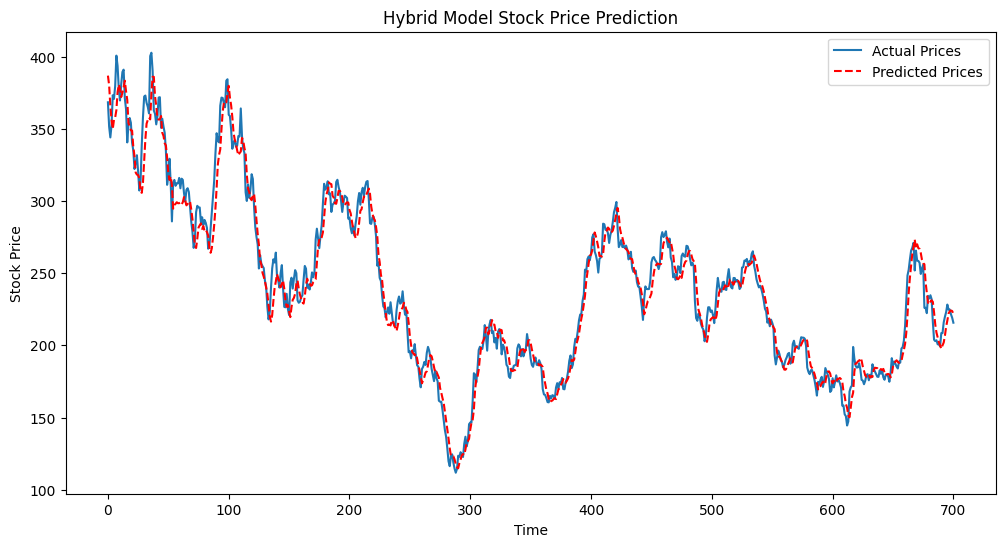

In [104]:
# Run the Hybrid Model on Stock Data
if __name__ == "__main__":
    X_train, y_train, X_test, y_test, scaler = load_and_preprocess_data('tesla_stock_data.csv')

    hybrid_model = build_hybrid_model()
    hybrid_model, history = train_hybrid_model(hybrid_model, X_train, y_train, X_test, y_test)

    evaluate_model(hybrid_model, X_test, y_test, scaler)